In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error # MSE probably not ideal, but good enough for now
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from pybaseball import batting_stats,pitching_stats,playerid_lookup

In [25]:
# train model on all of the data we have
# use all the same pca cols that were determined
dp = pd.read_csv('stats_and_pay_pitchers_topcols.csv')
db = pd.read_csv('stats_and_pay_batters_topcols.csv')

train0 = pd.merge(dp,db, on=['fgid','year','pay_adj','log_pay_adj'], how='outer')
train0 = train0[train0['pay_adj']>0]


side_cols = ['fgid','year','Season','Season_prev','pay','log_pay','adj','pay_adj','log_pay_adj']
columns_mask = np.logical_and.reduce([~np.isin(db.columns,side_cols),
                                      np.logical_or(db.dtypes==np.float64,db.dtypes==np.float64)])
batting_cols = train0.columns[np.isin(train0.columns,db.columns[columns_mask])]

columns_mask = np.logical_and.reduce([~np.isin(dp.columns,side_cols),
                                      np.logical_or(dp.dtypes==np.float64,dp.dtypes==np.float64)])
pitching_cols = train0.columns[np.isin(train0.columns,dp.columns[columns_mask])]

data_cols = list(pitching_cols)+list(batting_cols)

train = train0.copy().fillna(0)[data_cols].values
truths = train0['log_pay_adj'].values

train.shape

(6770, 331)

In [27]:
%%time

## Linear regression model
lin = LinearRegression(copy_X=True)
lin.fit(train, truths)

## random forest
regr = RandomForestRegressor(max_depth=12, random_state=None)
regr.fit(train, truths)

CPU times: user 20.9 s, sys: 7.47 ms, total: 20.9 s
Wall time: 19.5 s


RandomForestRegressor(max_depth=12)

In [62]:
b2023 = pd.read_csv('stats/fg_batting2023.csv')
p2023 = pd.read_csv('stats/fg_pitching2023.csv')

In [84]:
# load the list of free agents
df_free=pd.read_csv('2024_free_agents.csv')

In [85]:
is_bat = np.isin(df_free['fgid'].values,b2023.loc[:,'IDfg'].values)
is_pitch = np.isin(df_free['fgid'].values,p2023.loc[:,'IDfg'].values)

np.logical_or(is_bat,is_pitch).sum() # maybe some people don't have 2023 stats

177

In [86]:
# match them 
# create copies of the pitcher and batter stat dfs
db_new = b2023.loc[:, np.logical_and(b2023.columns != 'Season', b2023.columns != 'IDfg')].copy()
db_new['Season_prev'] = b2023.loc[:,'Season'].values
db_new['fgid'] = b2023.loc[:,'IDfg'].values

dp_new = p2023.loc[:, np.logical_and(p2023.columns != 'Season', p2023.columns != 'IDfg')].copy()
dp_new['Season_prev'] = p2023.loc[:,'Season'].values
dp_new['fgid'] = p2023.loc[:,'IDfg'].values

# there are some column names that are in both the batting and pitching tables
mapcol_p = {colname:'p_'+colname for colname in list(p2023.columns)[2:] if colname in list(b2023.columns)}
mapcol_b = {colname:'b_'+colname for colname in list(b2023.columns)[2:] if colname in list(p2023.columns)}

dp_new = dp_new.rename(columns=mapcol_p)
db_new = db_new.rename(columns=mapcol_b)

# merge
pitchers = pd.merge(df_free[is_pitch],dp_new, on=['fgid'], how='left')
batters = pd.merge(df_free[is_bat],db_new, on=['fgid'], how='left')
print(len(pitchers), len(batters),len(pitchers)+len(batters))

106 85 191


In [87]:
test0 = pd.merge(pitchers,batters, on=['fgid'], how='outer')
test = test0[data_cols].fillna(0).values

In [88]:
test.shape

(177, 331)

In [89]:
pred0 = lin.predict(test)
pred1 = regr.predict(test)

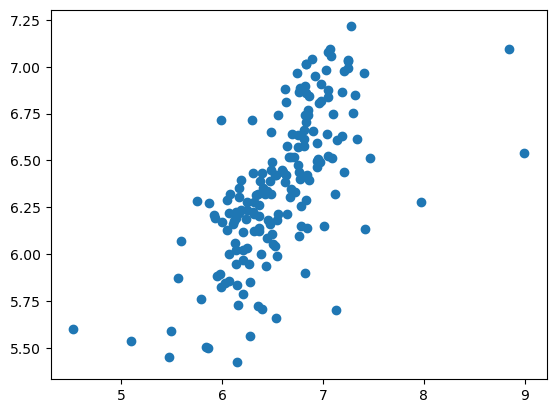

In [90]:
plt.scatter(pred0, pred1)

(array([ 8.,  6., 13., 20., 35., 33., 22., 16., 17.,  7.]),
 array([5.42130153, 5.60063266, 5.77996378, 5.9592949 , 6.13862602,
        6.31795714, 6.49728826, 6.67661938, 6.85595051, 7.03528163,
        7.21461275]),
 <BarContainer object of 10 artists>)

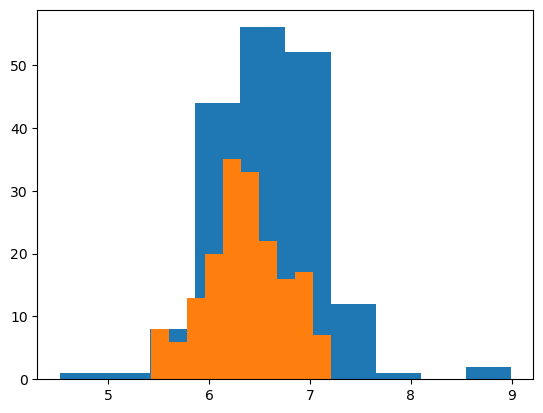

In [91]:
plt.hist(pred0)
plt.hist(pred1)

In [99]:
train0[train0['fgid']==19755]

,fgid,year,pay_adj,log_pay_adj,age_x,p_Age,W,L,p_WAR,ERA,...,b_Soft%+,b_Med%+,b_Hard%+,b_EV,b_LA,b_Barrels,b_maxEV,b_HardHit,b_Events,L-WAR
2874,19755,2021,3399000.000,6.531351,26.0,25.0,0.0,1.0,-0.1,37.80,...,116.0,90.0,107.0,89.1,9.2,11.0,111.9,44.0,103.0,0.0
3307,19755,2022,5769500.000,6.761138,27.0,26.0,9.0,2.0,3.0,3.18,...,66.0,85.0,140.0,93.6,16.8,78.0,119.0,187.0,350.0,5.1
4788,19755,2018,666535.000,5.823823,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5282,19755,2019,780650.000,5.892456,NaN,NaN,NaN,NaN,NaN,NaN,...,58.0,99.0,122.0,92.9,12.3,32.0,113.9,113.0,226.0,2.7
5752,19755,2020,307481.174,5.487819,NaN,NaN,NaN,NaN,NaN,NaN,...,52.0,92.0,131.0,92.8,6.7,32.0,115.1,131.0,280.0,1.7


In [100]:
# now let's print it out
for ind, row in enumerate(df_free[np.logical_or(is_bat,is_pitch)].iterrows()):
    print(ind, row[1].fgid, row[1].FirstName+' '+row[1].LastName, '%.2f'%10**pred0[ind])

0 1744 miguel cabrera 690203546.21
1 19755 shohei ohtani 5880676.68
2 13431 marcus stroman 4936615.07
3 12979 javier báez 11075388.64
4 4314 joey votto 12621351.35
5 14444 hyun jin ryu 1162339.06
6 2036 clayton kershaw 12235667.56
7 11899 joc pederson 16259220.32
8 2520 lance lynn 6827232.36
9 11368 yasmani grandal 3366097.35
10 16376 michael conforto 9483601.35
11 3548 liam hendriks 9620388.64
12 2233 adam wainwright 7201639.74
13 15998 cody bellinger 2325926.89
14 9368 evan longoria 1461606.44
15 5343 brandon crawford 6409558.40
16 13164 eduardo rodriguez 1597520.01
17 14765 julio urías 4226002.80
18 14212 josh hader 4778946.50
19 13066 teoscar hernández 19095937.03
20 12049 kyle hendricks 7995418.90
21 13301 max muncy 7772726.05
22 8048 will smith 17619710.53
23 11445 mark canha 1539374.09
24 13273 ross stripling 1056057.52
25 15873 sean manaea 6698400.69
26 15423 andrew heaney 11231942.76
27 16505 matt chapman 29317960.88
28 13781 alex wood 9250925.13
29 4106 michael brantley 16074